In [21]:
import os
import pandas as pd
from google.cloud import aiplatform
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def evaluate_results(data, target, endpt):
    data = data.astype(str)
    X = data.drop(target, axis = 1)
    y = data[target]
    y_pred = pd.Series()
    for i in range(len(data)):
        if i % 1000 == 0:
            print(i) #keep track of progress
        test = dict(X.iloc[i])
        try:
            results = endpt.predict([test])
            if results[0][0]['scores'][0] > 0.5:
                y_pred[i] = 0
            else:
                y_pred[i] = 1
        except Exception: 
            print(f"Skipping{i}")
            continue
    return y.astype(int), y_pred
    

In [3]:
def get_stats(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    re = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    return [acc, pre, re, f]

In [4]:
kf_endpoint = aiplatform.Endpoint(endpoint_name = 'projects/319407066227/locations/us-east1/endpoints/4942339951225208832')

In [19]:
kf_test = pd.read_csv('kf_test_317.csv')

kf_test.shape

In [21]:
kf_results = evaluate_results(kf_test, 'is_addtocart', kf_endpoint)

kf_true = kf_results[0].astype(int)
kf_pred = kf_results[1]

In [5]:
acc = accuracy_score(kf_true, kf_pred)
print(acc)

In [5]:
re = recall_score(kf_true, kf_pred)
print(re)

In [ ]:
f1 = f1_score(kf_true, kf_pred)
print(f1)

In [26]:
kf_true.value_counts()

is_addtocart
0    29162
1     5987
Name: count, dtype: int64

In [32]:
#export to csv
kf_test['prediction'] = kf_pred
kf_test = kf_test.drop(0, axis =1)
kf_test.to_csv('predictions_317.csv')

In [ ]:
#testing data for all 2017 
stats_df = pd.DataFrame(columns = ['month', 'count', 'acc', 'pre', 're', 'f1'])
for i in range (1,13): 
    df = pd.read_csv(f'validation_data/kf_test_{i}17.csv')
    test1, test2 = train_test_split(df, test_size = 0.5, random_state = 15) #only use half the data from each
    y_true, y_pred = evaluate_results(test1, 'is_addtocart', kf_endpoint)
    stats = get_stats(y_true, y_pred)
    stats_df.loc[len(stats_df)] = [i] + [len(y_true)] + stats
    print (f"done with {i}")  

0


In [35]:
stats_df.to_csv('validation_stats_2017.csv', index = False)

In [23]:
stats_df = pd.read_csv('validation_stats_2017.csv')

In [32]:
stats_df = stats_df.drop('Unnamed: 0', axis = 1)

In [36]:
stats_df

,month,count,acc,pre,re,f1
0,1,15528.0,1.000000,1.0,1.000000,1.000000
1,2,14144.0,1.000000,1.0,1.000000,1.000000
2,3,17574.0,0.999943,1.0,0.999662,0.999831
3,4,17017.0,0.999824,1.0,0.998965,0.999482
4,5,16760.0,0.999045,1.0,0.994326,0.997155
5,6,15419.0,0.999805,1.0,0.998875,0.999437
6,7,19183.0,0.999896,1.0,0.999386,0.999693
7,8,1336.0,1.000000,1.0,1.000000,1.000000


In [42]:
df_melted = pd.melt(stats_df.drop('count', axis =1), id_vars=['month'], var_name='Series', value_name='Values')

Text(0.5, 1.0, 'Performance Metrics by Month, 2017')

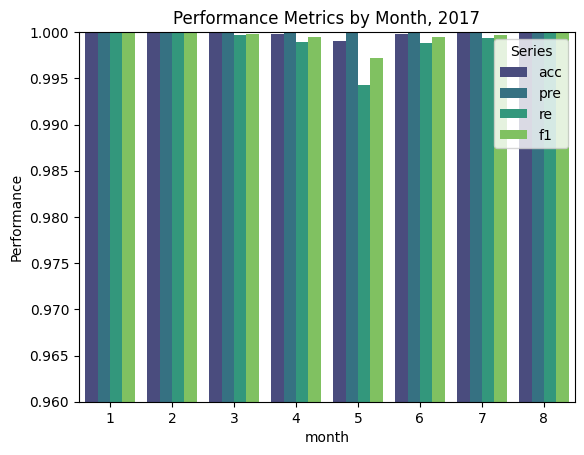

In [48]:
sns.barplot(x='month', y='Values', hue='Series', data=df_melted, palette='viridis')
plt.ylim(0.96, 1.0)
plt.ylabel("Performance")
plt.title("Performance Metrics by Month, 2017")

In [49]:
plt.savefig('figures/validation_performance.png', bbox_inches="tight")

<Figure size 640x480 with 0 Axes>